#  Uncertainty Quantification for Economists

# Agenda
### 1. Overview
### 2. Ishigami Equation as Toy Model
### 3. Uncertainty Propagation
### 4. Univaraite Effects
### 5. Sobol Indices

## References <a name="references"></a>

Feinberg, J., Langtagen, H. P. (2015) ["Chaospy: An open source tool for designing methods of uncertainty quantification"](https://www.sciencedirect.com/science/article/pii/S1877750315300119), Journal of Computational Science, 11: pp. 46-57.

Harenberg, D., Marelli, S., Sudret B., Winschel V. (2019). ["Uncertainty quantification and global sensitivity analysis for economic models"](https://onlinelibrary.wiley.com/doi/abs/10.3982/QE866), Quantitative Economics, 10(1): 1-41.

Smith, R. C. (2013). [Uncertainty Quantification: Theory, Implementation, and Applications](https://my.siam.org/Store/Product/viewproduct/?ProductId=24973024). SIAM. Philadelphia, Pennsylvania.

Sullivan, T. J. (2015). [Introduction to uncertainty quantification](https://www.semanticscholar.org/paper/Introduction-to-uncertainty-quantification-Sullivan/733938adeeb70a5a1463d64c1447397d926bb64b). Springer, Heidelberg.

## Abbreviations

UQ - Uncertainty Quantification\
QoI - Quantity of Interest\
GSA - Global Sensitivity Analysis

## Sources of Uncertainty

(i) model errors or discrepancies\
(ii) input uncertainties\
(iii) numerical errors and uncertainties\
(iv) measurement errors and uncertainties

# Basic UQ framework

## <center> Figure 1: UQ framework </center>
<img src="_notebook_material/uq_framework.png" width="66%" align="center"/>

In Step A, the computational model $M$ is defined. This requires to identify input parameters and output QoIs.  
In Step B, the uncertainty in the input paramters is described by a joint PDF that best represents the available information.  
In Step C, uncertainty propagation is carried out so as to analyze the moments and distributions of the QoI, for instance by plotting histograms.  
Finally, in Step C', sensitivity analysis is carried out to rank the input parameters according to their impact onto the predicition uncertainty, or to identify the direction of change of that impact. The acquired knowledge can be used to focus a more detailed analysis on a subset of the input variables.  
Resulting from the first analysis round, the model and its parameter composition might be changed. Then the process might be repeated.

A important decision when executing an UQ is whether to use Monte Carlo simulation (MCS) or a surrogate model that serves as an easy-to-evaluate approximation of the model that returns the QoI.
The reason that one might want to choose the second option is that computationally expensive models slow down MCS methods even more - given their naturally slow convergence.

# Overview of UQ discipline

The below figure depicts the model-based predictive estimation process in the light of a fully-fledged Uncertainty Quantification. It regards all four sources of model uncertainty as well as the need for additional advanced mathematical methods to use surrogate models.

## <center> Figure 2: Components of predictive estimation with UQ </center>
<img src="_notebook_material/uq_flowchart.png" width="66%" align="center"/>

As also highlighted by the first figure, Model Calibration and Uncertainty Propagation are the driving objectives.
Local Sensitity analysis in contrast to global sensitivity analysis aims at quantifying the effect of a subset of paramters on the QoI - but only for evaluations at a subset of the domain. The remaining topics are required to achieve these objectives for large-scale applications.
Stochastic Spectral Methods, e.g. Stochastic Galerkin, collocation or discrete projection mehtods provide options for computing surrogate models. Sparse grid methods are requred to implement stochastic spectral methods and for direct implementation of Bayesian model calibation methods when paramter dimensions are moderate.

# 2. Ishigami Equation
# $f(x) = sin(x_1) + a sin^2(x_2) + b x_3^4sin(x_1)$

$\implies$ Known partial variances and Sobol indices + high variance + interesting interaction effect

In [1]:
import chaospy as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from barplot import barplot
from distplot import distplot
from univariate_effects_plot import univariate_effects_plot

In [2]:
def ishigami(q0, q1, q2, a=2, b=3):
    f = np.sin(q0) + a*(np.sin(q1))**2 + b*q2**4*np.sin(q0)
    
    labels = ['d', 'd1', 'd2', 'd3', 'd12', 'd13', 'd23', 'd123']
    vals = [0.5 + (a**2)/8 + (b*(np.pi**4))/5 + ((b**2)*(np.pi**8)/18),
            (0.5 + b*(np.pi**4)/5 + (b**2)*(np.pi**8)/50), (a**2)/8,
            0, 0, (8*b**2*np.pi**8)/225, 0, 0]
    dvars = pd.Series(vals, index = labels)
    return f, dvars

# Step A: Model of the system / Assessment criteria
### Wrap the model as a QoI function in terms of input parameters

In [3]:
def qoi_model_wrapper(q0, q1, q2):
    return ishigami(q0, q1, q2)[0]

# Step B: <s>Quantification</s> Assumptions of sources of Uncertainty

In [4]:
d_q0 = cp.Uniform(-np.pi, np.pi)
d_q1 = cp.Uniform(-np.pi, np.pi)
d_q2 = cp.Uniform(-np.pi, np.pi)

joint_dist = cp.J(d_q0, d_q1, d_q2)

# 3. Step C: Uncertainty propagation

In [5]:
n_iter = 10000
mc_pars = joint_dist.sample(n_iter)
mc_evals = []
for i in range(0, n_iter):
    mc_evals.append(qoi_model_wrapper(*mc_pars[:,i]))

(<matplotlib.axes._subplots.AxesSubplot at 0x1bd0ad362e8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1bd0ad362e8>)

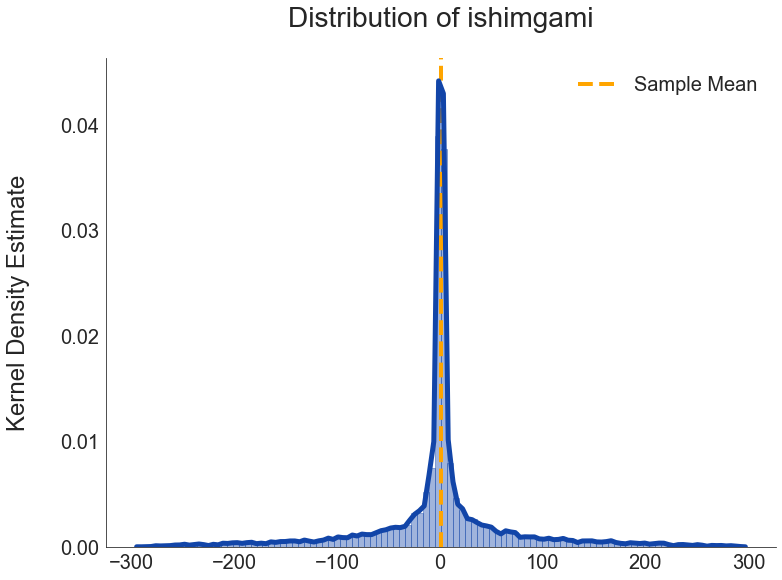

In [6]:
distplot(mc_evals, 'ishimgami')

Additionally, one may compute some descriptive statistics

# Step C': Sensitivity Analysis

# 4. Univariate Effects

Univaraite Effects:
Can be defined as the conditional expectation of a quantity of interest as a function of a single parameter, where expectations are taken over all other parameters.
# $M_i^{(i)}(x_i)=E[M(X|X_i=x_i)]$

In [7]:
pars = ['q0', 'q1', 'q2']
value= [0]*3
lower = [-np.pi]*3
upper = [np.pi]*3

df = pd.DataFrame(list(zip(value, lower, upper)), index = pars, columns = ['value', 'lower', 'upper'])
df

,value,lower,upper
q0,0,-3.141593,3.141593
q1,0,-3.141593,3.141593
q2,0,-3.141593,3.141593


(<Figure size 720x1296 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001BD0BA8E5C0>,
       dtype=object))

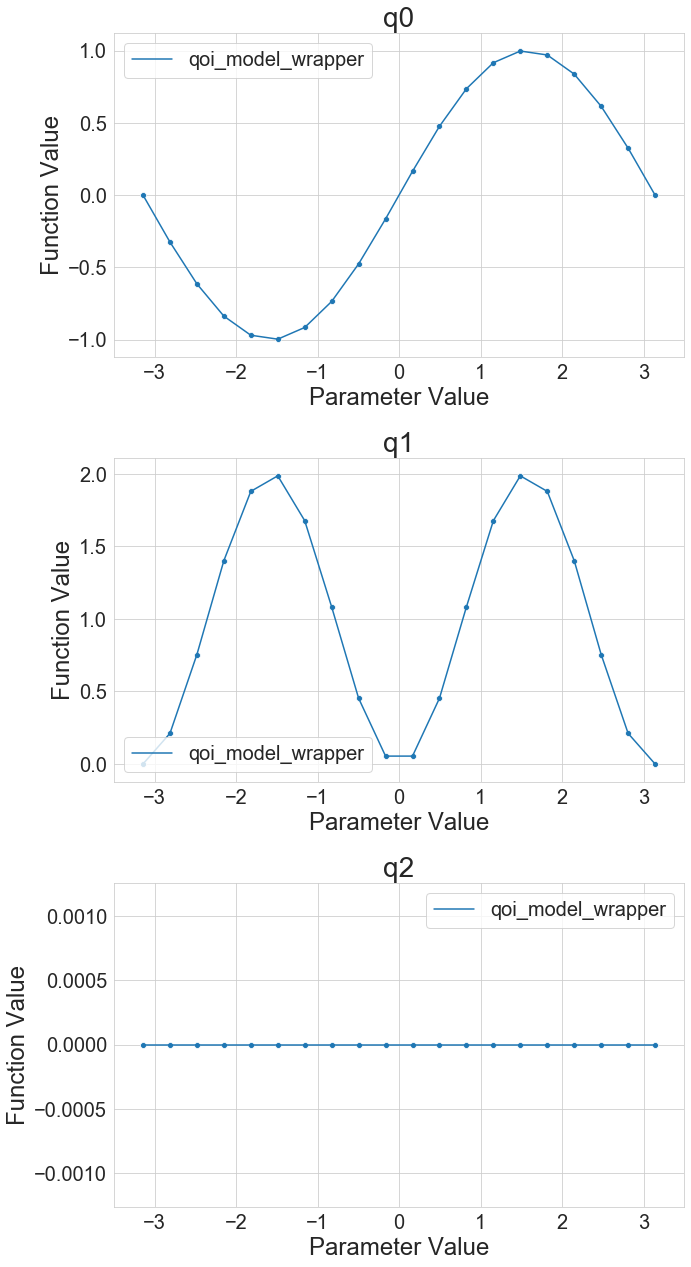

In [8]:
univariate_effects_plot(qoi_model_wrapper, df)

# 5. Sobol' indices
- based on a variance decomposition\
(exists if function/model M is square-integrable)

\begin{align}
Y = \mathcal{M}(\text{x}) = \mathcal{M}_0 + \sum_{i=1}^{M} \mathcal{M}_i(x_i) + \sum_{1 \leq i \leq j \leq M} \mathcal{M}_{ij}(x_i,x_j) + ... + \mathcal{M}_{12..M}(\text{x})
\end{align}

\begin{align}
\text{Var}[Y] =  \sum_{i=1}^{M} \text{Var}[\mathcal{M}_i(x_i)] + \sum_{1 \leq i \leq j \leq M} \text{Var}[\mathcal{M}_{ij}(x_i,x_j)] + ... + \text{Var}[\mathcal{M}_{12..M}(\text{x})]
\end{align}

### Take the variance attributed only to $x_i$ and normalize it for comparability

\begin{align}
S_i = \frac{\text{Cov}[\mathcal{M}_i(x_i), Y]}{\text{Var}[Y]}
\end{align}

\begin{align}
S_i = \frac{\text{Var}[\mathcal{M}_i(x_i)]}{\text{Var}[Y]} + \frac{\text{Cov}[\mathcal{M}_i(x_i), Y - \mathcal{M}_i(x_i)]}{\text{Var}[Y]}
\end{align}

### <span style="color:red"> Assume independence of $x_i$'s </span>

\begin{align}
S_i = \frac{\text{Var}_i[\mathcal{M}_i(x_i)]}{\text{Var}[Y]}
\end{align}

\begin{align}
S_{ij} = \frac{\text{Var}_{ij}[\mathcal{M}_{ij}(x_i,x_j)]}{\text{Var}[Y]}
\end{align}

\begin{align}
S_{u} = \frac{\text{Var}_{u}[\mathcal{M}_{u}(x_u)]}{\text{Var}[Y]}
\end{align}

\begin{equation}
\begin{aligned}
S_i^T = S_i + \sum_{j \ne i} S_{ij} + \sum_{1 \leq i \leq j \leq M,\{j,k\} \ne i} S_{ijk} + ... = \sum_{i \in \text{w}} S_\text{w} = \\
\frac{1}{\text{Var}[Y]}\sum_{i \in \text{w}} \text{Var}_i[\mathcal{M}_\text{w}(x_\text{w})]
\end{aligned}
\end{equation}

## Written as expectation
\begin{align}
S_i = \frac{\text{Var}_i[Y|X_i ]}{\text{Var}[Y]}
\end{align}

\begin{align}
S_i = \frac{\text{Var}_i[E_{\sim i}[Y|X_i ]]}{\text{Var}[Y]}
\end{align}

\begin{align}
S_{ij} = \frac{\text{Var}_{ij}[E_{\sim \{i,j\}}[Y|X_i, X_j ]]}{\text{Var}[Y]} - S_i - S_j
\end{align}

\begin{align}
S_\text{u} = \frac{\text{Var}_\text{u}[E_{\sim \text{u}}[Y|X_\text{u} ]]}{\text{Var}[Y]} - \sum_{\text{w} \subset \text{u}} S_\text{w}
\end{align}

\begin{align}
S_i^\text{T} = \sum_{i \in \text{u}} S_\text{u}
\end{align}

# What can you already say about the Sobol' indices of the Ishigami Equation?
# $f(x) = sin(x_1) + a sin^2(x_2) + b x_3^4sin(x_1)$

\begin{align}
S_i = \frac{\text{Var}_i[E_{\sim i}[Y|X_i ]]}{\text{Var}[Y]}
\end{align}

In [9]:
def di_3d(function, dist_1, dist_2, dist_3, outer_iter, inner_iter, ish_order='abc'):
    
    mc_sample = np.ones([outer_iter, inner_iter])*np.nan
    cond_exp = np.ones([outer_iter])*np.nan
    
    for i in range(0, outer_iter):
        if ish_order.startswith('a') == True:
            q1 = float(dist_1.sample(1))
            for j in range (0, inner_iter):
                # if correlated, sample conditionally on q1
                q2 = float(dist_2.sample(1))
                q3 = float(dist_3.sample(1))
                mc_sample[i,j] = function(q1, q2, q3)
            cond_exp[i] = np.mean(mc_sample[i,:])    
                
        elif ish_order.startswith('b') == True:
            q1 = float(dist_2.sample(1))
            for j in range (0, inner_iter):
                # if correlated, sample conditionally on q2
                q2 = float(dist_1.sample(1))
                q3 = float(dist_3.sample(1))
                mc_sample[i,j] = function(q2, q1, q2)
            cond_exp[i] = np.mean(mc_sample[i,:])    
                
        elif ish_order.startswith('c') == True:
            q1 = float(dist_3.sample(1))
            for j in range (0, inner_iter):
                # if correlated, sample conditionally on q3
                q2 = float(dist_1.sample(1))
                q3 = float(dist_2.sample(1))
                mc_sample[i,j] = function(q3, q1, q2)
            cond_exp[i] = np.mean(mc_sample[i,:])
        else:
            raise ValueError('Dummy!')

    
    di = np.var(cond_exp)
    
    return di#, cond_exp, mc_sample 

# Higher-order indices are obtained like above except that the lower order indices must be subtracted.

# For total indices use 
\begin{align}
S_{i}^T = \frac{E_{\sim i}[\text{Var}_{i}[Y|X_{\sim i}]]}{\text{Var}[Y]}
\end{align}

In [10]:
def di_tot_3d(function, dist_1, dist_2, dist_3, outer_iter, inner_iter, ish_order='abc'):

    par_sample = np.empty([outer_iter, inner_iter], dtype=object) # dtype allows to add lists
    mc_sample = np.ones([outer_iter, inner_iter])*np.nan
    cond_var = np.ones([outer_iter])*np.nan
    
    for i in range(0, outer_iter):
        if ish_order.startswith('ab') == True or ish_order.startswith('ba') == True:
                q0 = float(dist_1.sample(1))
                q1 = float(dist_2.sample(1))
                for j in range (0, inner_iter):
                    # if correlated, sample on all other variables
                    q2 = float(dist_3.sample(1))
                    par_sample[i,j] = [q0, q1, q2]
                    mc_sample[i,j] = function(q0, q1, q2)

        elif ish_order.startswith('bc') == True or ish_order.startswith('cb') == True:
                q1 = float(dist_2.sample(1)) # order changed
                q2 = float(dist_3.sample(1))
                for j in range (0, inner_iter):
                    # if correlated, sample on all other variables
                    q0 = float(dist_1.sample(1))
                    par_sample[i,j] = [q1, q2, q0]
                    mc_sample[i,j] = function(q0, q1, q2)

        elif ish_order.startswith('ac') == True or ish_order.startswith('ca') == True:
                q0 = float(dist_1.sample(1)) # order changed
                q2 = float(dist_3.sample(1))
                for j in range (0, inner_iter):
                    # if correlated, sample on all other variables
                    q1 = float(dist_2.sample(1))
                    par_sample[i,j] = [q0, q2, q1]
                    mc_sample[i,j] = function(q0, q1, q2)

        else:
            raise ValueError('Refocus!')

        cond_var[i] = np.var(mc_sample[i,:])

    
    di_tot = np.mean(cond_var)
    
    return di_tot, cond_var, mc_sample, par_sample 

In [11]:
d0 = di_3d(qoi_model_wrapper, d_q0, d_q1, d_q2, 10, 9, ish_order='abc')
d1 = di_3d(qoi_model_wrapper, d_q0, d_q1, d_q2, 10, 9, ish_order='bca')
d2 = di_3d(qoi_model_wrapper, d_q0, d_q1, d_q2, 10, 9, ish_order='cab')

d0_tot = di_tot_3d(qoi_model_wrapper, d_q0, d_q1, d_q2, outer_iter=10, inner_iter=9, ish_order='abc')
d1_tot = di_tot_3d(qoi_model_wrapper, d_q0, d_q1, d_q2, outer_iter=10, inner_iter=9, ish_order='bca')
d2_tot = di_tot_3d(qoi_model_wrapper, d_q0, d_q1, d_q2, outer_iter=10, inner_iter=9, ish_order='cab')

d = np.var(mc_evals)
e = np.mean(mc_evals) # 0 is true
d, e

(4748.791396346729, 1.005387775536046)

# Results of 10k x 2k MC simulation

In [12]:
d1_q0 = 1759.5729627292585
d1_q1 = 1.174482974962664
d1_q2 = 2.9008984287347297

d_tot_q0 = 4885.007472084101
d_tot_q1 = 0.4995974276055311
d_tot_q2 = 3041.8031655592313
first_order   = [d1_q0/d, d1_q1/d, d1_q2/d]
tot_order    = [d_tot_q0/d, d_tot_q1/d, d_tot_q2/d]

print('true partial variances:')
ishigami(99, 99, 99, a=2, b=3)[1]

true partial variances:


d       4803.710963
d1      1766.881038
d2         0.500000
d3         0.000000
d12        0.000000
d13     3036.329925
d23        0.000000
d123       0.000000
dtype: float64

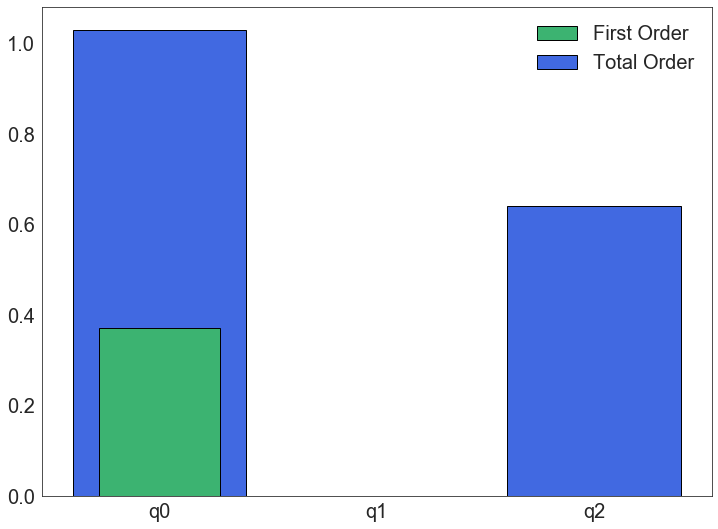

In [13]:
barplot(first_order, tot_order)
# So far, it astonishes me that the first order effect for q1 is so small compared to q0

# What remains to compute for the future: PCE-based Sobol' Indices

# Handy because the partial variance $\text{Var}_{u}[\mathcal{M}_{u}(x_u)]$ is given by the sum of squared coefficients of the respective parameters u

## Challenges: Chaospy uses MC instead of Post-processing PCE-coefficients +  coeffs are presented "chaotically" ;)
### Therefore, univariate effects and Sobol' indices are much harder to obtain than necessary.

In [ ]:
# fit a general poly form
poly_large = cp.orth_ttr(9, joint_dist)
poly_illustrate = cp.orth_ttr(3, joint_dist)
#approximate it on mc sample
approx = cp.fit_regression(poly_large, mc_pars, mc_evals)



#first_order = cp.Sens_m(approx, joint_dist)

print(poly_illustrate)

In [ ]:
cp.E(approx, joint_dist) # 0 is true

In [ ]:
cp.Std(approx, joint_dist)**2 # variance is almost exact.

# Results for variance and expectation are more precise vor higher order polynomials compared to moderately large MC sample
